In [1]:
# Importer les librairies de Python
import warnings
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from keras.utils.np_utils import to_categorical #

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from tensorflow.keras.datasets import mnist

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('pas de GPU')
print('GPU est: {}'.format(device_name))
print('Version de Tensorflow', tf.__version__)

GPU est: /device:GPU:0
Version de Tensorflow 2.5.0


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

NB_LABELED = 100 
INPUT_SHAPE = 128 
HEIGHT = 28
WIDTH = 28

LEAK_ALPHA = 0.1
NB_PER_CLASS = NB_LABELED//10
LABELS = 10

LAMBDA = 1
DATA_SIZE = X_train.shape[0] - NB_LABELED
BATCH_SIZE = 100
Epsilon = 1e-7
Epochs = 20
Num_steps = DATA_SIZE//BATCH_SIZE

In [3]:
def normalize_img(img):
    img = img.astype('float32')/255.0 
    img = (img - 0.5)/0.5
    return img

def denormalize_img(img):
    img = (img*0.5+0.5)*255.0
    return img.astype('uint8')

def get_data(start_index, end_index , X_train):
    NUM_SAMPLES = end_index - start_index
    x_batch = X_train[start_index:end_index]
    z_noise = np.random.uniform(-1,1,INPUT_SHAPE * NUM_SAMPLES).reshape((NUM_SAMPLES,INPUT_SHAPE))
    return x_batch,z_noise

# Récupérer les données
X_train = np.expand_dims(X_train , axis = -1).astype('uint8')
X_test = np.expand_dims(X_test , axis = -1).astype('uint8')

X_train = normalize_img(X_train)
X_test = normalize_img(X_test)

# extraire 10 exemples de chaque chiffre
X_100 = np.zeros((NB_LABELED,HEIGHT,WIDTH,1))
y_100 = np.zeros(NB_LABELED)
idx_labaled = np.array([]).astype('int')
for i in range(LABELS):
  Item_index = np.where(y_train==i)[0]
  np.random.seed(44)
  INDEX_PER_CLASS = np.random.choice(list(Item_index),NB_PER_CLASS , replace = False)
  X_100[i*NB_PER_CLASS:(i+1)*NB_PER_CLASS,:,:,:] = X_train[INDEX_PER_CLASS,:,:]
  y_100[i*NB_PER_CLASS:(i+1)*NB_PER_CLASS] = y_train[INDEX_PER_CLASS,]
  idx_labaled = np.concatenate((idx_labaled,np.array(INDEX_PER_CLASS)))

y_100 = to_categorical(y_100 , num_classes = LABELS)

# supprimer les 100 exemples labellisées.
X_train = np.delete(X_train, idx_labaled, axis=0)

In [4]:
# filter_shape est de la forme [filter_height, filter_width, in_channels, out_channels]
def weights(filter_shape , name ):
    w = tf.get_variable(name, shape = filter_shape,initializer=tf.random_normal_initializer(0, 0.1))
    return w

# shape_ est de la forme [out_channels]
def bias(shape_ , name):
    b = tf.get_variable(name, shape = shape_ ,initializer=tf.random_normal_initializer(1, 0.5))
    return b

# Couche de convolution avec un activation
def conv2d(x, W, bias, padding='SAME', activation='relu' , name='conv2d' , strides = [1,1]):
    with tf.variable_scope(name):
        output = tf.nn.conv2d(x, W, strides=[1, *strides, 1], padding = padding) + bias
        if activation=='leakyrelu':
            return tf.nn.leaky_relu(output, alpha = LEAK_ALPHA)
        elif activation=='sigmoid' :
            return tf.nn.sigmoid(output)
        elif activation=='tanh' :
            return tf.nn.tanh(output)
        else :
           return output

# Couche d'upsampling avec des zeros sur les bords du volume d'entrée.
def upsample2d(x , strides = (2,2)):
    x_shape = x.get_shape()
    h1 = x_shape[1] // strides[0]
    h2 = x_shape[2] // strides[1]
    paddings = tf.constant([[0,0] ,[h1,h1] , [h2,h2] , [0,0]])
    return tf.pad(x,paddings, mode='constant')

# Couche de Max-Pooling2D
def maxpool2d(x , strides = (2,2) , kernel_size = (3,3)):
    return tf.nn.max_pool(x, ksize=[1, *kernel_size, 1], strides=[1, *strides, 1], padding='SAME')

# Couche de Batch-Normalization
def batchnorm(x,is_training=True,reuse=True,scope='BatchNormalization' , decay=0.85):
    bn = tf.layers.batch_normalization(x , momentum = decay, training=is_training ,reuse=reuse,name=scope)
    return bn

In [5]:
# Generateur :
# input_x est l'entrée du générateur.
# reuse est un booléen qui indique de réutiliser un générateur du même nom dans le graphe.
# training est un booléen qui indique le statut du réseau (entraînement ou inférence)
def Generator(input_x ,reuse=False, training=True, name ="Generator" ):
    with tf.variable_scope(name, reuse=reuse):
        W_fc = weights([INPUT_SHAPE , 8 * 8 * 96 ] , 'kernel1')
        b_fc = bias([8 * 8 * 96], 'bias1')
        h_fc = tf.nn.leaky_relu(tf.matmul(input_x, W_fc) + b_fc , alpha = LEAK_ALPHA)
        h_fc = batchnorm(h_fc , scope='bn1', is_training = training , reuse = reuse , decay = 0.9)
        img_0 = tf.reshape(h_fc, [-1, 8, 8, 96])
        h_t1 = upsample2d(img_0)
        ###########
        W_t1 = weights([3, 3, 96 , 96] , 'kernel2')
        b_t1 = bias([96], 'bias2')
        h_t1 = conv2d(h_t1, W_t1, b_t1, activation='leakyrelu', name='conv1')
        h_t1 = batchnorm(h_t1 ,scope='bn2', is_training =training, reuse = reuse , decay = 0.9 )
        ###########
        W_t1 = weights([5, 5, 96 , 96] , 'kernel3')
        b_t1 = bias([96], 'bias_3')
        h_t1 = conv2d(h_t1, W_t1, b_t1, activation='leakyrelu', name='conv2')
        h_t1 = batchnorm(h_t1 ,scope='bn3', is_training =training, reuse = reuse , decay = 0.9 )
        ##########
        W1 = weights([5, 5, 96 , 64], 'kernel4')
        b1 = bias([64], 'bias4')
        h1 = conv2d(h_t1, W1, b1, activation='leakyrelu', name='conv3')
        h1 = batchnorm(h1,scope='bn4',is_training =training,reuse=reuse,decay = 0.9)
        h_t2 = upsample2d(h1) #
        ###########
        W_t2 = weights([3, 3, 64 , 64] , 'kernel5')
        b_t2 = bias([64] , 'bias5')
        h_t2 = conv2d(h_t2, W_t2, b_t2, activation='leakyrelu', name='conv4')
        h_t2 = batchnorm(h_t2,scope='bn5',is_training =training,reuse=reuse,decay=0.9)
        ###########
        W_t2 = weights([3, 3, 64 , 64] , 'kernel6')
        b_t2 = bias([64], 'bias6')
        h_t2 = conv2d(h_t2, W_t2, b_t2, activation='leakyrelu', name='conv5')
        h_t2 = batchnorm(h_t2 ,scope='bn6', is_training =training, reuse = reuse , decay = 0.9 )
        ###########
        W2 = weights([5, 5, 64, 64] , 'kernel7')
        b2 = bias([64], 'bias7')
        h2 = conv2d(h_t2, W2, b2 , padding='VALID',activation='leakyrelu', name='conv6')
        h2 = batchnorm(h2 , scope='bn7', is_training =training, reuse = reuse , decay = 0.9 )
        ###########
        W3 = weights([1, 1, 64, 1] , 'kernel8')
        b3 = bias([1] , 'bias8')
        h3 = conv2d(h2, W3, b3 , padding='VALID',activation='tanh', name='conv7') # (? , 28 , 28 , 1 )
    return h3


# Discriminateur :
# input_x est l'entrée du Discriminateur.
# reuse est un booléen qui indique de réutiliser un Discriminateur du même nom dans le graphe.
# training est un booléen qui indique le statut du réseau (entraînement ou inférence)
def Discriminator(input_x ,reuse=False , training=True , name="Discriminator"):
    with tf.variable_scope(name , reuse=reuse):
        W0 = weights([5, 5, 1, 32] , 'kernel1')
        b0 = bias([32], 'bias1')
        h0 = conv2d(input_x, W0, b0, activation='leakyrelu', name='conv1' , strides = [2,2])
        h0 = batchnorm(h0 , scope='bn1', is_training =training , reuse = reuse , decay = 0.9)
        h_pool = maxpool2d(h0 , strides=(2,2),kernel_size=(3,3))
        ##################
        W1 = weights([3, 3, 32, 64] , 'kernel2')
        b1 = bias([64], 'bias_2')
        h1 = conv2d(h_pool, W1, b1, activation='leakyrelu', name='conv2')
        h1 = batchnorm(h1 , scope='bn2', is_training =training , decay = 0.9 , reuse = reuse)
        ##################
        W2 = weights([3, 3, 64, 64] , 'kernel3')
        b2 = bias([64], 'bias3')
        h2 = conv2d(h1, W2, b2, activation='leakyrelu', name='conv3' , strides = [2,2])
        h2 = batchnorm(h2 , scope='bn3', is_training =training , decay = 0.9 , reuse = reuse)
        h_pool_1 = maxpool2d(h2 , strides=(2,2),kernel_size=(3,3))
        ##################
        W3 = weights([3, 3, 64, 128] , 'kernel4')
        b3 = bias([128] , 'bias4')
        h3 = conv2d(h_pool_1, W3, b3, activation='leakyrelu', name='conv4')
        h3 = batchnorm(h3 , scope='bn4', is_training =training , decay = 0.9 , reuse = reuse)
        ##################
        W4 = weights([1, 1, 128, 10] , 'kernel5')
        b4 = bias([10] , 'bias5')
        h4 = conv2d(h3, W3, b3, activation='leakyrelu', name='conv5')
        h4 = batchnorm(h4 , scope='bn5', is_training =training , decay = 0.9 , reuse = reuse)
        ##################
        h4_shape = h4.get_shape()
        h_flattened = tf.reshape(h4, [-1, h4_shape[1] *h4_shape[2]*h4_shape[3]])
        W_fc = weights([h_flattened.get_shape()[1], 128] , 'kernel6')
        b_fc = bias([128], 'bias6')
        h_fc = tf.nn.leaky_relu(tf.matmul(h_flattened, W_fc) + b_fc , alpha = LEAK_ALPHA)
        h_fc = batchnorm(h_fc , scope='bn6', is_training =training , decay = 0.9 , reuse = reuse)
        ##################
        W_fc_out = weights([128, LABELS] , 'kernel7')
        b_fc_out = bias([LABELS], 'bias7')
        logits = tf.matmul(h_fc, W_fc_out) + b_fc_out
        probs = tf.nn.softmax(logits , axis= -1)
    return logits,probs

In [6]:
tf.reset_default_graph()
with tf.device('/gpu:0'):
    # mettre en place les PlaceHolders pour les entrées du graphes
    is_training = tf.placeholder(tf.bool, [] , name = "is_training")
    noise_input = tf.placeholder(tf.float32, shape = [None, INPUT_SHAPE] , name = 'nois_input') # Loi uniforme
    X_input = tf.placeholder(tf.float32, shape = [None, HEIGHT, WIDTH, 1], name = 'X_input') # Non-labelisee
    X_labeled = tf.placeholder(tf.float32, shape = [None, HEIGHT, WIDTH, 1], name = 'X_labeled')

    y_input = tf.placeholder(tf.float32, shape = [None, LABELS], name = 'y_input')
    # Générateur va prendre du bruit et génère un échantillon
    generated_sample = Generator(noise_input, training = is_training)
    # Discriminateur va faire un prédiction sur les données réelles non labellisées et les données générées
    real_logits, d_real = Discriminator(X_input, training = is_training)
    fake_logits, d_fake = Discriminator(generated_sample, reuse = True, training = is_training)
    # Construction de la fonction loss du Discriminator :
    entropy_d_real = tf.reduce_mean(d_real , 0)
    H_x_y_D = - tf.reduce_sum(entropy_d_real * tf.log(entropy_d_real + Epsilon))# +1e-6 pour éviter que d_real soit nul
    E_H_fake = - tf.reduce_sum(d_fake * tf.log(d_fake + Epsilon))/BATCH_SIZE
    E_H_real = - tf.reduce_sum(d_real * tf.log(d_real + Epsilon))/BATCH_SIZE

    # Construction de la partie supervisée de la fonction loss du Discriminateur : (Binary Cross Entropy)
    real_logits_labaled, d_real_labeled = Discriminator(X_labeled, reuse = True, training = is_training)
    E_H_real_0 = - tf.reduce_sum(d_real_labeled * tf.log(d_real_labeled + Epsilon))/100
    CE_y_real = - tf.reduce_sum(y_input * tf.log(d_real_labeled + Epsilon) , reduction_indices=[1])
    cost = tf.reduce_mean(CE_y_real)
    d_loss = - H_x_y_D + E_H_real + E_H_real_0 - E_H_fake + LAMBDA * cost # disc loss
    # Construction de la fonction loss du Générateur :
    entropy_d_fake = tf.reduce_mean(d_fake , 0)
    H_x_y_G = - tf.reduce_sum(entropy_d_fake * tf.log(entropy_d_fake + Epsilon))
    g_loss = - H_x_y_G + E_H_fake
    # Le taux d'apprentissage
    
    d_optimizer = tf.train.AdamOptimizer(learning_rate = 2e-4)# , beta1 = 0.5 , beta2 = 0.9)
    g_optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4)# , beta1 = 0.5 , beta2 = 0.9)

    # Récupérer les variables de chaque réseau séparément
    # Récupérer les variables de la couche Batch-normalization parce qu'ils
    # ne sont pas enregistrées dans tf.GraphKeys.TRAINABLE_VARIABLES
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Generator')
    g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope = 'Generator')
    train_gen = tf.group([g_optimizer.minimize(g_loss, var_list = gen_vars) , g_update_ops])

    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'Discriminator')
    d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope = 'Discriminator')
    train_disc = tf.group([d_optimizer.minimize(d_loss, var_list = disc_vars) , d_update_ops])

    predictions = tf.argmax(d_real, axis=1 , name='predictions')
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    # Le graphe est sauvegardée sur TensorBoard
    writer = tf.summary.FileWriter('logs')
    writer.add_graph(sess.graph)
    D_loss_tab = []
    G_loss_tab = []
    ACC = []
    for i in range(1 , Epochs + 1):
        start_time = time.time()
        for j in range(Num_steps):
            start_index = j*BATCH_SIZE
            end_index = (j+1) * BATCH_SIZE
            if j == Num_steps - 1 :
                start_index = j*BATCH_SIZE
                end_index = DATA_SIZE

            x_batch,z_noise = get_data(start_index, end_index, X_train)
            feed_dict = {noise_input: z_noise ,
                         X_input : x_batch ,
                         X_labeled : X_100 ,
                         y_input : y_100 , 
                         is_training: True}
            _,_,gl,dl = sess.run([train_disc , train_gen , g_loss , d_loss], feed_dict = feed_dict)       
            G_loss_tab.append(gl)
            D_loss_tab.append(dl)
        if i%2 == 0:
            feed_dict = {X_input: X_test, is_training : False }
            y_predicted = sess.run(predictions, feed_dict = feed_dict)
            ACC.append(np.mean(y_test == y_predicted))
            print(' || Epoch : ',i , 
                  ' || Accuracy : ', accuracy_score(y_test,y_predicted) ,
                  ' || Time : ' , np.round((time.time() - start_time)/60 , decimals=3))

Instructions for updating:
Colocations handled automatically by placer.
 || Epoch :  2  || Accuracy :  0.8414  || Time :  0.51
 || Epoch :  4  || Accuracy :  0.8789  || Time :  0.486
 || Epoch :  6  || Accuracy :  0.8916  || Time :  0.487
 || Epoch :  8  || Accuracy :  0.8939  || Time :  0.486
 || Epoch :  10  || Accuracy :  0.9006  || Time :  0.486
 || Epoch :  12  || Accuracy :  0.9175  || Time :  0.487
 || Epoch :  14  || Accuracy :  0.9222  || Time :  0.487
 || Epoch :  16  || Accuracy :  0.9309  || Time :  0.487
 || Epoch :  18  || Accuracy :  0.9434  || Time :  0.487
 || Epoch :  20  || Accuracy :  0.9544  || Time :  0.486


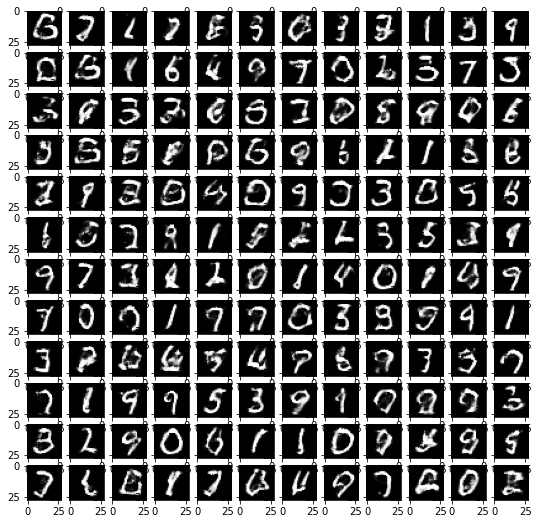

In [7]:
nb = 12
z = np.random.uniform(-1,1,INPUT_SHAPE * nb * nb).reshape((nb * nb,INPUT_SHAPE))
imgs_test = sess.run(generated_sample , feed_dict={is_training:False , noise_input :z})
imgs_test = denormalize_img(imgs_test)
fig, axs = plt.subplots(nb, nb , figsize = (9,9))
for i in range(nb):
    for j in range(nb):
        ip = i*nb + j
        axs[i,j].imshow(imgs_test[ip,:,:,0], cmap = plt.cm.gray)

plt.show()